In [1]:
from UTILITY_quickstart import *
from scipy.optimize import minimize

importedDefaultSettings = loadConfig("setLattice_configs/defaults.yml") | loadConfig("setLattice_configs/bounds.yml")

tao = initializeTao()

setLattice(tao, **importedDefaultSettings)

launchTwissCorrection(tao)

Environment set to:  /Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao
Tracking to end
CSR off
Overwriting lattice with setLattice() defaults
No defaults file provided to setLattice(). Using setLattice_configs/defaults.yml
WARNING! No beam file is specified!
Number of macro particles defined by input file
Beam created, written to /Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/beams/activeBeamFile.h5, and reinit to tao
No evalElement provided. Assuming golden lattice PR10571
Optimization Results:
Optimal Parameters: [0.13755652 0.953558   0.40561699 2.20425982]
Objective Function Value at Optimal Parameters: 3.3948865246987365e-09
Number of Iterations: 235
Converged: True


In [2]:
startElement = "BEGBC20"
endElement = "MFFF"
collElement = "CN2069"

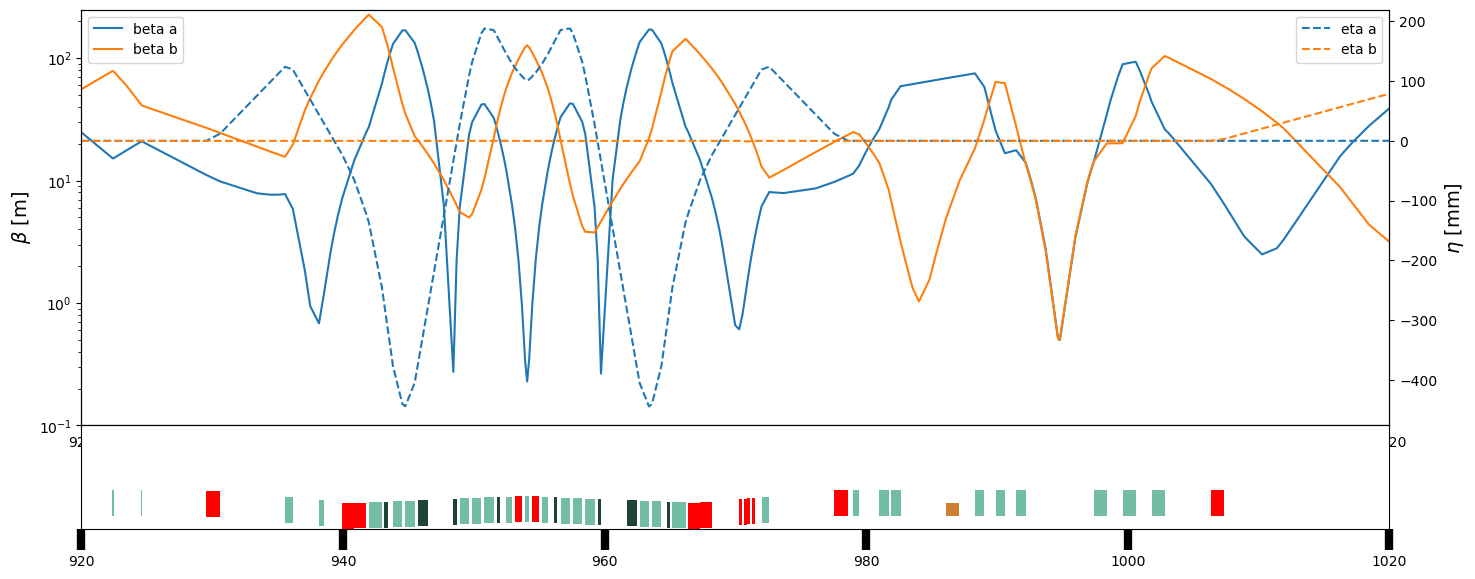

In [3]:
floorplanPlot(
    tao,
    zmin = 920,
    zmax = 1020,
    ymin = 0.1,
    ymax = 250
)

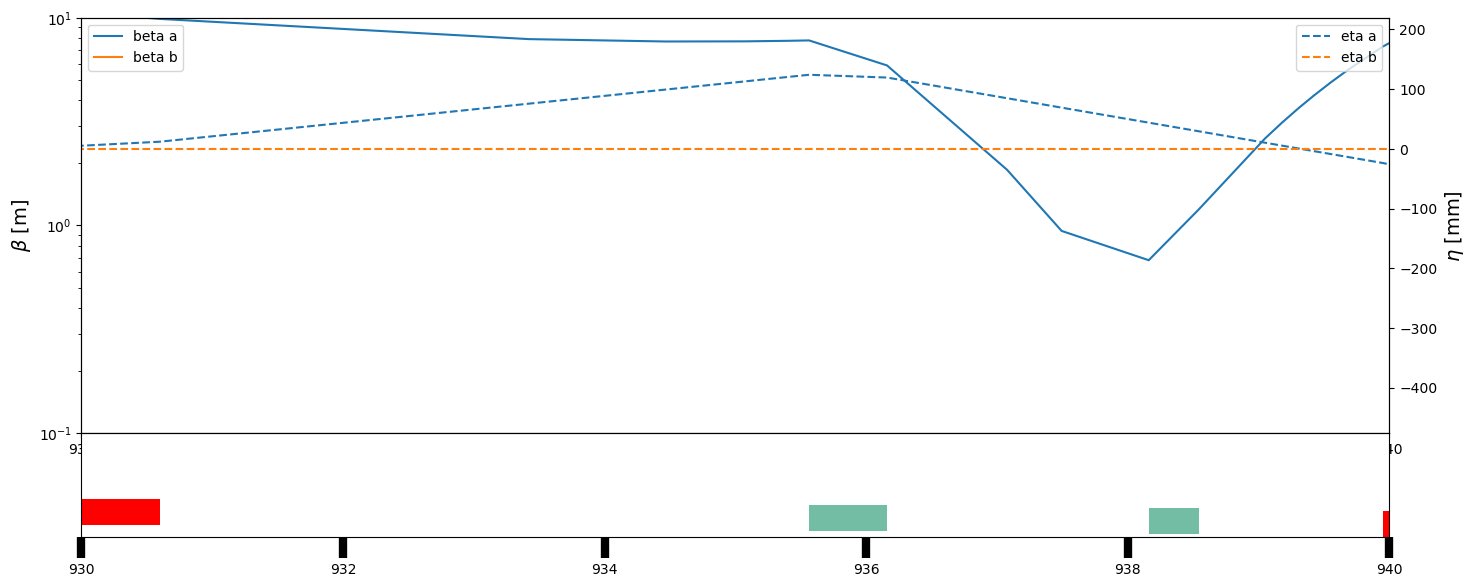

In [4]:
floorplanPlot(
    tao,
    zmin = 930,
    zmax = 940,
    ymin = 0.1,
    ymax = 10
)

In [5]:
baselineTransportMatrix = getMatrix( tao, startElement, endElement, print = True)
baselineTransportVector = getMatrix( tao, startElement, endElement, order = 0, print = True)

-1.208675,-4.962570,-0.000000,-0.000000,0.000000,0.000012
-0.084965,-1.176201,0.000000,0.000000,0.000000,-0.000001
-0.000000,-0.000000,-0.637675,6.526881,0.000000,-0.000000
-0.000000,-0.000000,-0.094432,-0.601645,0.000000,-0.000000
-0.000003,-0.000021,0.000000,-0.000000,1.000000,-0.007001
0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


0.000000
0.000000
-0.000000
-0.000000
-0.000000
0.000000


In [6]:
tao.ele_twiss(collElement)

{'mode_flip': False,
 'beta_a': 1.85234094964851,
 'alpha_a': 1.43702279995933,
 'gamma_a': 1.65468162229235,
 'phi_a': 56.2403412777264,
 'eta_a': 0.0847957852511347,
 'etap_a': -0.0377727137210963,
 'beta_b': 37.4124043047606,
 'alpha_b': -11.194342665257,
 'gamma_b': 3.37624138449501,
 'phi_b': 53.8075691104267,
 'eta_b': 2.01168032964826e-18,
 'etap_b': 5.22367895463407e-19,
 'eta_x': 0.0847957852511347,
 'etap_x': -0.0377727137210963,
 'eta_y': 2.23130682137974e-18,
 'etap_y': 6.36390258772237e-19}

In [7]:
tao.cmd(f"show ele {collElement}")

['Element # 1308',
 'Element Name: CN2069',
 'Element Type:  "notch"',
 'Key: Rcollimator',
 'S_start, S:    937.077555,    937.077555',
 'Ref_time_start, Ref_time:  3.125771E-06,  3.125771E-06',
 '',
 'Attribute values [Only non-zero values shown]:',
 '    1  L                           =  0.0000000E+00 m',
 '   10  FRINGE_TYPE                 =  None (1)               11  FRINGE_AT                   =  Both_Ends (3)',
 '   13  SPIN_FRINGE_ON              =  T (1)',
 '   17  STATIC_LINEAR_MAP           =  F (0)',
 '   53  P0C                         =  9.9984356E+09 eV           BETA                        =  1.0000000E+00',
 '   54  E_TOT                       =  9.9984356E+09 eV           GAMMA                       =  1.9566450E+04',
 '   64  REF_TIME_START              =  3.1257713E-06 sec      50  DELTA_REF_TIME              =  0.0000000E+00 sec',
 '   65  INTEGRATOR_ORDER            = 0',
 '   67  DS_STEP                     =  2.0000000E-01 m        66  NUM_STEPS               

In [8]:
np.sum(( 0*baselineTransportMatrix - baselineTransportMatrix )**2)

72.85641372367118

In [9]:
freeParameters = ["Q1EkG", "Q2EkG"]
initialGuess = [ importedDefaultSettings[param] for param in freeParameters ]
initialGuess

[161.311, -154.229]

In [10]:

bounds = [ eval(importedDefaultSettings[ param + "Bounds"]) for param in freeParameters ]
bounds

[(0, 388), (-364, 0)]

In [11]:


def objective(params, tao):
    overrides = { freeParameters[i] : params[i] for i in range(len(freeParameters)) }
    
    try:
        #Prevent recalculation until changes are made
        tao.cmd("set global lattice_calc_on = F")
        
        setLattice(tao, **( importedDefaultSettings | overrides ) )
        
        #Reenable lattice calculations
        tao.cmd("set global lattice_calc_on = T")
    
    except: #If Bmad doesn't like the proposed solution, don't crash, give a bad number
        return 1e20

    collBeta = tao.ele_twiss(collElement)["beta_a"]

    
    return collBeta

In [12]:
    
from scipy.optimize import minimize


# Perform optimization using Nelder-Mead
result = minimize(
    objective, 
    initialGuess, #Starting point
    method='Nelder-Mead',
    bounds = bounds,
    args = (tao, )
)



                      
print("Optimization Results:")
print(f"Optimal Parameters: {result.x}")
print(f"Objective Function Value at Optimal Parameters: {result.fun}")
print(f"Number of Iterations: {result.nit}")
print(f"Converged: {result.success}")



Optimization Results:
Optimal Parameters: [304.43877408 -53.52367014]
Objective Function Value at Optimal Parameters: 0.192879947980745
Number of Iterations: 57
Converged: True
